In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from skimage.measure import label, regionprops
import glob

###################################
# 1) REUSE YOUR GLOW MODEL CLASSES
###################################

class BaseDistribution(nn.Module):
    def __init__(self, mean=torch.tensor([0.0, 0.0]), std=torch.tensor([1.0, 1.0])):
        super().__init__()
        self.dist = torch.distributions.MultivariateNormal(
            loc=mean, covariance_matrix=torch.diag(std**2)
        )

    def sample(self, num_samples):
        return self.dist.sample((num_samples,))

    def log_prob(self, x):
        return self.dist.log_prob(x)

class ActNorm(nn.Module):
    def __init__(self, dim, init=True):
        super().__init__()
        self.dim = dim
        self.initialized = (not init)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.zeros(dim))

    def initialize_params(self, x):
        with torch.no_grad():
            mean = x.mean(dim=0)
            std = x.std(dim=0)
            self.bias.data = -mean
            self.log_scale.data = torch.log(1.0/(std + 1e-6))
        self.initialized = True

    def forward(self, x, cond=None):
        if not self.initialized:
            self.initialize_params(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        # Per-sample log_det
        log_det = self.log_scale.sum() * torch.ones(x.size(0), device=x.device)
        return y, log_det

    def inverse(self, y, cond=None):
        x = y * torch.exp(-self.log_scale) - self.bias
        log_det = -self.log_scale.sum() * torch.ones(y.size(0), device=y.device)
        return x, log_det

class Invertible1x1Conv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        w_init = torch.qr(torch.randn(dim, dim))[0]
        self.weight = nn.Parameter(w_init)
        self.dim = dim

    def forward(self, x, cond=None):
        y = x @ self.weight
        log_det = torch.logdet(self.weight) * torch.ones(x.size(0), device=x.device)
        return y, log_det

    def inverse(self, y, cond=None):
        W_inv = torch.inverse(self.weight)
        x = y @ W_inv
        log_det = -torch.logdet(self.weight) * torch.ones(y.size(0), device=y.device)
        return x, log_det

class AffineCouplingGLOW(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        self.cond_dim = cond_dim
        self.net = nn.Sequential(
            nn.Linear(self.half_dim + cond_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, self.half_dim * 2),
        )

    def forward(self, x, cond):
        x1 = x[:, :self.half_dim]
        x2 = x[:, self.half_dim:]

        input_net = torch.cat([x1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)
        y2 = x2 * torch.exp(scale) + shift
        y = torch.cat([x1, y2], dim=1)

        log_det = scale.sum(dim=1)
        return y, log_det

    def inverse(self, y, cond):
        y1 = y[:, :self.half_dim]
        y2 = y[:, self.half_dim:]

        input_net = torch.cat([y1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)

        x2 = (y2 - shift) * torch.exp(-scale)
        x = torch.cat([y1, x2], dim=1)
        log_det = -scale.sum(dim=1)
        return x, log_det

class GLOWStep(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.actnorm = ActNorm(dim)
        self.inv_conv = Invertible1x1Conv(dim)
        self.coupling = AffineCouplingGLOW(dim, cond_dim)

    def forward(self, x, cond):
        x, ldj_act = self.actnorm(x)
        x, ldj_conv = self.inv_conv(x)
        x, ldj_coup = self.coupling(x, cond)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

    def inverse(self, y, cond):
        x, ldj_coup = self.coupling.inverse(y, cond)
        x, ldj_conv = self.inv_conv.inverse(x)
        x, ldj_act = self.actnorm.inverse(x)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

class NormalizingFlow(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = nn.ModuleList(steps)

    def forward(self, x, cond):
        total_ldj = 0
        for step in self.steps:
            x, ldj = step.forward(x, cond)
            total_ldj += ldj
        return x, total_ldj

    def inverse(self, z, cond):
        total_ldj = 0
        for step in reversed(self.steps):
            z, ldj = step.inverse(z, cond)
            total_ldj += ldj
        return z, total_ldj

class FlowModel(nn.Module):
    def __init__(self, flow, base_dist):
        super().__init__()
        self.flow = flow
        self.base_dist = base_dist

    def forward(self, x, cond):
        z, log_det_jacobian = self.flow.forward(x, cond)
        log_prob = self.base_dist.log_prob(z) + log_det_jacobian
        return log_prob

    def sample(self, num_samples, cond):
        z = self.base_dist.sample(num_samples)
        x, _ = self.flow.inverse(z, cond)
        return x

###################################################
# 2) HELPER FUNCTIONS (sample points, measure, etc.)
###################################################

def sample_points_inside_bubble(bubble_data, num_points):
    indices = np.argwhere(bubble_data > 0)
    if indices.size == 0:
        return np.empty((0, 2))
    chosen_indices = indices[np.random.choice(len(indices), size=num_points, replace=True)]
    offsets = np.random.rand(num_points, 2)
    points = chosen_indices + offsets
    return points

def compute_ray_lengths(bubble_data, num_rays, start_point):
    from scipy.ndimage import gaussian_filter
    nx, ny = bubble_data.shape
    sigma = 1
    smoothed_bubble = gaussian_filter(bubble_data, sigma=sigma)
    contour_level = 0.3 * np.max(smoothed_bubble)  # Adjusted as per the training script
    interp_func = RegularGridInterpolator(
        (np.arange(nx), np.arange(ny)),
        smoothed_bubble,
        bounds_error=False, 
        fill_value=0
    )
    angles = np.deg2rad(np.linspace(0, 360, num_rays, endpoint=False))
    distances = []
    max_distance = np.hypot(nx, ny)
    sx, sy = start_point

    for angle in angles:
        ray_dx = np.cos(angle)
        ray_dy = np.sin(angle)
        distances_along_ray = np.linspace(0, max_distance, num=1000)
        intersection_found = False
        for distance in distances_along_ray:
            x_point = sx + distance * ray_dx
            y_point = sy + distance * ray_dy
            if 0 <= x_point < nx and 0 <= y_point < ny:
                value = interp_func((x_point, y_point))
                if value <= contour_level:
                    distances.append(distance)
                    intersection_found = True
                    break
            else:
                distances.append(distance)
                intersection_found = True
                break
        if not intersection_found:
            distances.append(max_distance)
    ray_lengths = np.array(distances)
    return ray_lengths, angles

def create_density_map(samples, grid_shape):
    """
    Takes (x, y) samples, places them into a 2D array 'density_map' of shape (nx, ny).
    Here:
      - grid_shape[0] = nx = number of rows
      - grid_shape[1] = ny = number of columns
    We interpret x -> columns, y -> rows, so:
      row = floor(y), col = floor(x).
    """
    x_coords = samples[:, 0]
    y_coords = samples[:, 1]
    x_indices = np.clip(np.floor(x_coords).astype(int), 0, grid_shape[1] - 1)
    y_indices = np.clip(np.floor(y_coords).astype(int), 0, grid_shape[0] - 1)

    density_map = np.zeros(grid_shape, dtype=np.float32)
    for col, row in zip(x_indices, y_indices):
        density_map[row, col] += 1
    return density_map

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return np.nan
    return 1 - (ss_res / ss_tot)

def compute_r2_row_col(real_data, model_data):
    """
    1) row sums => axis=1
    2) col sums => axis=0
    3) normalize each => distribution
    4) R²(row_sums), R²(col_sums) => average
    """
    row_sum_real = real_data.sum(axis=1)
    row_sum_model = model_data.sum(axis=1)
    if row_sum_real.sum() == 0 or row_sum_model.sum() == 0:
        return np.nan
    row_sum_real /= row_sum_real.sum()
    row_sum_model /= row_sum_model.sum()

    col_sum_real = real_data.sum(axis=0)
    col_sum_model = model_data.sum(axis=0)
    if col_sum_real.sum() == 0 or col_sum_model.sum() == 0:
        return np.nan
    col_sum_real /= col_sum_real.sum()
    col_sum_model /= col_sum_model.sum()

    r2_row = r2_score(row_sum_real, row_sum_model)
    r2_col = r2_score(col_sum_real, col_sum_model)
    return (r2_row + r2_col) / 2.0

###########################################
# 3) MAIN SCRIPT: sample, measure, compute
###########################################
def main():
    # ----------------- A) Load model + checkpoint
    checkpoint_path = "NEWLONG512GLOW.pth"  # Updated checkpoint path
    dim = 2
    layers_count = 8  # Updated to match the training script
    num_rays_per_point = 6
    cond_dim = 2 + num_rays_per_point

    flow_steps = [GLOWStep(dim, cond_dim) for _ in range(layers_count)]
    flow = NormalizingFlow(flow_steps)
    base_dist = BaseDistribution()
    model = FlowModel(flow, base_dist)

    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint '{checkpoint_path}' not found. Exiting.")
        return

    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    data_x_mean = checkpoint['data_x_mean']
    data_x_std  = checkpoint['data_x_std']
    data_c_mean = checkpoint['data_c_mean']
    data_c_std  = checkpoint['data_c_std']
    epoch_used  = checkpoint['epoch']
    print(f"Loaded checkpoint from epoch {epoch_used}.")

    # ----------------- B) Parameters for sampling + R²
    num_samples_per_condition = 5000  # Adjusted as per user preference
    num_points_per_bubble = 24        # Updated to match training
    new_size = 512
    sigma = 5.0

    output_file = "txtfiles/NEWLONGz09r2_results_all_planes_8_512.txt"

    # Write header
    with open(output_file, "w") as f_out:
        f_out.write("plane\tslice\tbubble_id\tvolume\tECC\tr2_percent\n")

    # Planes and slices to process
    planes = ['xy', 'yz', 'zx']
    slice_range = range(10, 191)  # Adjust slice range as needed
    for plane in planes:
        for slice_num in tqdm(slice_range, desc=f"Processing Plane {plane}"):
            bubble_files = glob.glob(f"{plane}_extracted_bubbles/isolated_bubbles/slice_{slice_num}_bubble_*_isolated.npy")
            bubble_ids = [int(os.path.basename(f).split('_')[3]) for f in bubble_files]

            for bubble_id in bubble_ids:
                # Real data path + bubble data path
                density_path = f"{plane}_extracted_bubbles/halo_density_patches/slice_{slice_num}_bubble_{bubble_id}_halo_density_filtered.npy"
                bubble_path  = f"{plane}_extracted_bubbles/isolated_bubbles/slice_{slice_num}_bubble_{bubble_id}_isolated.npy"

                if not os.path.exists(density_path) or not os.path.exists(bubble_path):
                    print(f"No data for bubble {bubble_id} in slice {slice_num}, skipping.")
                    continue

                density_grid = np.load(density_path)  # shape (nx, ny)
                bubble_data  = np.load(bubble_path)   # shape (nx, ny)

                nx, ny = density_grid.shape

                # ----------------- C) Compute volume (2D area) + eccentricity
                labeled = label(bubble_data > 0)
                if labeled.max() == 0:
                    bubble_volume = 0
                    bubble_ecc = 0.0
                else:
                    props = regionprops(labeled)
                    props_sorted = sorted(props, key=lambda p: p.area, reverse=True)
                    main_region = props_sorted[0]
                    bubble_volume = main_region.area
                    bubble_ecc = main_region.eccentricity

                # ----------------- D) Collect conditions (random points inside bubble)
                valid_cond_vectors = []
                attempts = 0
                max_attempts = 3000

                while len(valid_cond_vectors) < num_points_per_bubble and attempts < max_attempts:
                    attempts += 1
                    pts = sample_points_inside_bubble(bubble_data, 1)
                    if pts.size == 0:
                        continue
                    sp = pts[0]
                    ray_lengths, _ = compute_ray_lengths(bubble_data, num_rays_per_point, sp)
                    norm_val = np.linalg.norm(ray_lengths)
                    if norm_val == 0 or np.isnan(norm_val):
                        continue
                    ray_lengths_norm = ray_lengths / norm_val
                    if np.any(np.isnan(ray_lengths_norm)):
                        continue
                    cond_vec = np.concatenate([sp, ray_lengths_norm])
                    cond_vec_norm = (cond_vec - data_c_mean) / data_c_std
                    valid_cond_vectors.append(cond_vec_norm)

                if len(valid_cond_vectors) == 0:
                    print(f"No valid conditions for bubble {bubble_id} in slice {slice_num}, skip.")
                    continue

                # ----------------- E) Sample from model + accumulate maps
                accumulated_maps = []

                with torch.no_grad():
                    for cond_vec_norm in valid_cond_vectors:
                        c_ten = torch.tensor(cond_vec_norm, dtype=torch.float32).unsqueeze(0)
                        cond_batch = c_ten.repeat(num_samples_per_condition, 1)
                        samples = model.sample(num_samples_per_condition, cond_batch)
                        samples_np = samples.numpy()
                        samples_dn = samples_np * data_x_std + data_x_mean
                        density_map = create_density_map(samples_dn, (nx, ny))
                        accumulated_maps.append(density_map)

                if len(accumulated_maps) == 0:
                    continue

                model_map_coarse = np.mean(accumulated_maps, axis=0)

                # ----------------- F) Upscale + smooth
                x_space = np.linspace(0, ny - 1, ny)
                y_space = np.linspace(0, nx - 1, nx)
                Xnew = np.linspace(0, ny - 1, new_size)
                Ynew = np.linspace(0, nx - 1, new_size)
                grid_x, grid_y = np.meshgrid(Xnew, Ynew)

                real_interp  = RegularGridInterpolator((y_space, x_space), density_grid,  bounds_error=False, fill_value=0)
                model_interp = RegularGridInterpolator((y_space, x_space), model_map_coarse, bounds_error=False, fill_value=0)

                fine_real  = real_interp((grid_y, grid_x))
                fine_model = model_interp((grid_y, grid_x))

                smoothed_real  = gaussian_filter(fine_real,  sigma=sigma)
                smoothed_model = gaussian_filter(fine_model, sigma=sigma)

                # ----------------- G) Compute R²
                r2_val = compute_r2_row_col(smoothed_real, smoothed_model)
                if np.isnan(r2_val):
                    continue
                r2_percent = 100.0 * r2_val

                # ----------------- H) Write results
                with open(output_file, "a") as f_out:
                    f_out.write(f"{plane}\t{slice_num}\t{bubble_id}\t{bubble_volume}\t{bubble_ecc:.4f}\t{r2_percent:.2f}\n")

    print(f"All done! Results in '{output_file}'.")

if __name__ == "__main__":
    main()


<ipython-input-1-656647e025f7>:60: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_19qm5ghvuj/croot/libtorch_1736268753361/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2428.)
  w_init = torch.qr(torch.randn(dim, dim))[0]
<ipython-input-1-656647e025f7>:299: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_o

RuntimeError: Error(s) in loading state_dict for FlowModel:
	Missing key(s) in state_dict: "flow.steps.0.coupling.net.3.weight", "flow.steps.0.coupling.net.3.bias", "flow.steps.0.coupling.net.5.weight", "flow.steps.0.coupling.net.5.bias", "flow.steps.1.coupling.net.3.weight", "flow.steps.1.coupling.net.3.bias", "flow.steps.1.coupling.net.5.weight", "flow.steps.1.coupling.net.5.bias", "flow.steps.2.coupling.net.3.weight", "flow.steps.2.coupling.net.3.bias", "flow.steps.2.coupling.net.5.weight", "flow.steps.2.coupling.net.5.bias", "flow.steps.3.coupling.net.3.weight", "flow.steps.3.coupling.net.3.bias", "flow.steps.3.coupling.net.5.weight", "flow.steps.3.coupling.net.5.bias", "flow.steps.4.coupling.net.3.weight", "flow.steps.4.coupling.net.3.bias", "flow.steps.4.coupling.net.5.weight", "flow.steps.4.coupling.net.5.bias", "flow.steps.5.coupling.net.3.weight", "flow.steps.5.coupling.net.3.bias", "flow.steps.5.coupling.net.5.weight", "flow.steps.5.coupling.net.5.bias", "flow.steps.6.actnorm.bias", "flow.steps.6.actnorm.log_scale", "flow.steps.6.inv_conv.weight", "flow.steps.6.coupling.net.0.weight", "flow.steps.6.coupling.net.0.bias", "flow.steps.6.coupling.net.2.weight", "flow.steps.6.coupling.net.2.bias", "flow.steps.6.coupling.net.3.weight", "flow.steps.6.coupling.net.3.bias", "flow.steps.6.coupling.net.5.weight", "flow.steps.6.coupling.net.5.bias", "flow.steps.6.coupling.net.6.weight", "flow.steps.6.coupling.net.6.bias", "flow.steps.7.actnorm.bias", "flow.steps.7.actnorm.log_scale", "flow.steps.7.inv_conv.weight", "flow.steps.7.coupling.net.0.weight", "flow.steps.7.coupling.net.0.bias", "flow.steps.7.coupling.net.2.weight", "flow.steps.7.coupling.net.2.bias", "flow.steps.7.coupling.net.3.weight", "flow.steps.7.coupling.net.3.bias", "flow.steps.7.coupling.net.5.weight", "flow.steps.7.coupling.net.5.bias", "flow.steps.7.coupling.net.6.weight", "flow.steps.7.coupling.net.6.bias". 
	Unexpected key(s) in state_dict: "flow.steps.0.coupling.net.8.weight", "flow.steps.0.coupling.net.8.bias", "flow.steps.0.coupling.net.2.running_mean", "flow.steps.0.coupling.net.2.running_var", "flow.steps.0.coupling.net.2.num_batches_tracked", "flow.steps.0.coupling.net.4.weight", "flow.steps.0.coupling.net.4.bias", "flow.steps.0.coupling.net.6.running_mean", "flow.steps.0.coupling.net.6.running_var", "flow.steps.0.coupling.net.6.num_batches_tracked", "flow.steps.1.coupling.net.8.weight", "flow.steps.1.coupling.net.8.bias", "flow.steps.1.coupling.net.2.running_mean", "flow.steps.1.coupling.net.2.running_var", "flow.steps.1.coupling.net.2.num_batches_tracked", "flow.steps.1.coupling.net.4.weight", "flow.steps.1.coupling.net.4.bias", "flow.steps.1.coupling.net.6.running_mean", "flow.steps.1.coupling.net.6.running_var", "flow.steps.1.coupling.net.6.num_batches_tracked", "flow.steps.2.coupling.net.8.weight", "flow.steps.2.coupling.net.8.bias", "flow.steps.2.coupling.net.2.running_mean", "flow.steps.2.coupling.net.2.running_var", "flow.steps.2.coupling.net.2.num_batches_tracked", "flow.steps.2.coupling.net.4.weight", "flow.steps.2.coupling.net.4.bias", "flow.steps.2.coupling.net.6.running_mean", "flow.steps.2.coupling.net.6.running_var", "flow.steps.2.coupling.net.6.num_batches_tracked", "flow.steps.3.coupling.net.8.weight", "flow.steps.3.coupling.net.8.bias", "flow.steps.3.coupling.net.2.running_mean", "flow.steps.3.coupling.net.2.running_var", "flow.steps.3.coupling.net.2.num_batches_tracked", "flow.steps.3.coupling.net.4.weight", "flow.steps.3.coupling.net.4.bias", "flow.steps.3.coupling.net.6.running_mean", "flow.steps.3.coupling.net.6.running_var", "flow.steps.3.coupling.net.6.num_batches_tracked", "flow.steps.4.coupling.net.8.weight", "flow.steps.4.coupling.net.8.bias", "flow.steps.4.coupling.net.2.running_mean", "flow.steps.4.coupling.net.2.running_var", "flow.steps.4.coupling.net.2.num_batches_tracked", "flow.steps.4.coupling.net.4.weight", "flow.steps.4.coupling.net.4.bias", "flow.steps.4.coupling.net.6.running_mean", "flow.steps.4.coupling.net.6.running_var", "flow.steps.4.coupling.net.6.num_batches_tracked", "flow.steps.5.coupling.net.8.weight", "flow.steps.5.coupling.net.8.bias", "flow.steps.5.coupling.net.2.running_mean", "flow.steps.5.coupling.net.2.running_var", "flow.steps.5.coupling.net.2.num_batches_tracked", "flow.steps.5.coupling.net.4.weight", "flow.steps.5.coupling.net.4.bias", "flow.steps.5.coupling.net.6.running_mean", "flow.steps.5.coupling.net.6.running_var", "flow.steps.5.coupling.net.6.num_batches_tracked". 
	size mismatch for flow.steps.0.coupling.net.0.weight: copying a param with shape torch.Size([256, 9]) from checkpoint, the shape in current model is torch.Size([512, 9]).
	size mismatch for flow.steps.0.coupling.net.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.0.coupling.net.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.0.coupling.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.0.coupling.net.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for flow.steps.0.coupling.net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for flow.steps.1.coupling.net.0.weight: copying a param with shape torch.Size([256, 9]) from checkpoint, the shape in current model is torch.Size([512, 9]).
	size mismatch for flow.steps.1.coupling.net.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.1.coupling.net.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.1.coupling.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.1.coupling.net.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for flow.steps.1.coupling.net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for flow.steps.2.coupling.net.0.weight: copying a param with shape torch.Size([256, 9]) from checkpoint, the shape in current model is torch.Size([512, 9]).
	size mismatch for flow.steps.2.coupling.net.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.2.coupling.net.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.2.coupling.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.2.coupling.net.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for flow.steps.2.coupling.net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for flow.steps.3.coupling.net.0.weight: copying a param with shape torch.Size([256, 9]) from checkpoint, the shape in current model is torch.Size([512, 9]).
	size mismatch for flow.steps.3.coupling.net.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.3.coupling.net.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.3.coupling.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.3.coupling.net.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for flow.steps.3.coupling.net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for flow.steps.4.coupling.net.0.weight: copying a param with shape torch.Size([256, 9]) from checkpoint, the shape in current model is torch.Size([512, 9]).
	size mismatch for flow.steps.4.coupling.net.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.4.coupling.net.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.4.coupling.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.4.coupling.net.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for flow.steps.4.coupling.net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for flow.steps.5.coupling.net.0.weight: copying a param with shape torch.Size([256, 9]) from checkpoint, the shape in current model is torch.Size([512, 9]).
	size mismatch for flow.steps.5.coupling.net.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.5.coupling.net.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.5.coupling.net.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for flow.steps.5.coupling.net.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for flow.steps.5.coupling.net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([2]).

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from skimage.measure import label, regionprops
import glob

###################################
# 1) REUSE YOUR GLOW MODEL CLASSES
###################################

class BaseDistribution(nn.Module):
    def __init__(self, mean=torch.tensor([0.0, 0.0]), std=torch.tensor([1.0, 1.0])):
        super().__init__()
        self.dist = torch.distributions.MultivariateNormal(
            loc=mean, covariance_matrix=torch.diag(std**2)
        )

    def sample(self, num_samples):
        return self.dist.sample((num_samples,))

    def log_prob(self, x):
        return self.dist.log_prob(x)

###################################
#         GLOW Components         #
###################################
class ActNorm(nn.Module):
    def __init__(self, dim, init=True):
        super().__init__()
        self.dim = dim
        self.initialized = (not init)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.zeros(dim))

    def initialize_params(self, x):
        with torch.no_grad():
            mean = x.mean(dim=0)
            std = x.std(dim=0)
            self.bias.data = -mean
            self.log_scale.data = torch.log(1.0 / (std + 1e-6))
        self.initialized = True

    def forward(self, x, cond=None):
        if not self.initialized:
            self.initialize_params(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        log_det = self.log_scale.sum().expand_as(x[:, 0])
        return y, log_det

    def inverse(self, y, cond=None):
        x = y * torch.exp(-self.log_scale) - self.bias
        log_det = -self.log_scale.sum().expand_as(y[:, 0])
        return x, log_det

class Invertible1x1Conv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        w_init = torch.qr(torch.randn(dim, dim))[0]
        self.weight = nn.Parameter(w_init)
        self.dim = dim

    def forward(self, x, cond=None):
        W = self.weight
        y = x @ W
        log_det = torch.logdet(W).expand_as(x[:, 0])
        return y, log_det

    def inverse(self, y, cond=None):
        W_inv = torch.inverse(self.weight)
        x = y @ W_inv
        log_det = -torch.logdet(self.weight).expand_as(y[:, 0])
        return x, log_det

class AffineCouplingGLOW(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        self.cond_dim = cond_dim
        self.net = nn.Sequential(
            nn.Linear(self.half_dim + cond_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, self.half_dim * 2),
        )

    def forward(self, x, cond):
        x1 = x[:, :self.half_dim]
        x2 = x[:, self.half_dim:]

        input_net = torch.cat([x1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)
        y2 = x2 * torch.exp(scale) + shift
        y = torch.cat([x1, y2], dim=1)

        log_det = scale.sum(dim=1)
        return y, log_det

    def inverse(self, y, cond):
        y1 = y[:, :self.half_dim]
        y2 = y[:, self.half_dim:]

        input_net = torch.cat([y1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)

        x2 = (y2 - shift) * torch.exp(-scale)
        x = torch.cat([y1, x2], dim=1)

        log_det = -scale.sum(dim=1)
        return x, log_det

class GLOWStep(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.actnorm = ActNorm(dim)
        self.inv_conv = Invertible1x1Conv(dim)
        self.coupling = AffineCouplingGLOW(dim, cond_dim)

    def forward(self, x, cond):
        x, ldj_act = self.actnorm(x)
        x, ldj_conv = self.inv_conv(x)
        x, ldj_coup = self.coupling(x, cond)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

    def inverse(self, y, cond):
        x, ldj_coup = self.coupling.inverse(y, cond)
        x, ldj_conv = self.inv_conv.inverse(x)
        x, ldj_act = self.actnorm.inverse(x)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

###################################
#     Normalizing Flow (GLOW)     #
###################################
class NormalizingFlow(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = nn.ModuleList(steps)

    def forward(self, x, cond):
        total_ldj = 0
        for step in self.steps:
            x, ldj = step.forward(x, cond)
            total_ldj += ldj
        return x, total_ldj

    def inverse(self, z, cond):
        total_ldj = 0
        for step in reversed(self.steps):
            z, ldj = step.inverse(z, cond)
            total_ldj += ldj
        return z, total_ldj

class FlowModel(nn.Module):
    def __init__(self, flow, base_dist):
        super().__init__()
        self.flow = flow
        self.base_dist = base_dist

    def forward(self, x, cond):
        z, log_det_jacobian = self.flow.forward(x, cond)
        log_prob = self.base_dist.log_prob(z) + log_det_jacobian
        return log_prob

    def sample(self, num_samples, cond):
        z = self.base_dist.sample(num_samples)
        x, _ = self.flow.inverse(z, cond)
        return x
###################################################
# 2) HELPER FUNCTIONS (sample points, measure, etc.)
###################################################

def sample_points_inside_bubble(bubble_data, num_points):
    indices = np.argwhere(bubble_data > 0)
    if indices.size == 0:
        return np.empty((0, 2))
    chosen_indices = indices[np.random.choice(len(indices), size=num_points, replace=True)]
    offsets = np.random.rand(num_points, 2)
    points = chosen_indices + offsets
    return points

def compute_ray_lengths(bubble_data, num_rays, start_point):
    from scipy.ndimage import gaussian_filter
    nx, ny = bubble_data.shape
    sigma = 1
    smoothed_bubble = gaussian_filter(bubble_data, sigma=sigma)
    contour_level = 0.3 * np.max(smoothed_bubble)  # Adjusted as per the training script
    interp_func = RegularGridInterpolator(
        (np.arange(nx), np.arange(ny)),
        smoothed_bubble,
        bounds_error=False, 
        fill_value=0
    )
    angles = np.deg2rad(np.linspace(0, 360, num_rays, endpoint=False))
    distances = []
    max_distance = np.hypot(nx, ny)
    sx, sy = start_point

    for angle in angles:
        ray_dx = np.cos(angle)
        ray_dy = np.sin(angle)
        distances_along_ray = np.linspace(0, max_distance, num=1000)
        intersection_found = False
        for distance in distances_along_ray:
            x_point = sx + distance * ray_dx
            y_point = sy + distance * ray_dy
            if 0 <= x_point < nx and 0 <= y_point < ny:
                value = interp_func((x_point, y_point))
                if value <= contour_level:
                    distances.append(distance)
                    intersection_found = True
                    break
            else:
                distances.append(distance)
                intersection_found = True
                break
        if not intersection_found:
            distances.append(max_distance)
    ray_lengths = np.array(distances)
    return ray_lengths, angles

def create_density_map(samples, grid_shape):
    """
    Takes (x, y) samples, places them into a 2D array 'density_map' of shape (nx, ny).
    Here:
      - grid_shape[0] = nx = number of rows
      - grid_shape[1] = ny = number of columns
    We interpret x -> columns, y -> rows, so:
      row = floor(y), col = floor(x).
    """
    x_coords = samples[:, 0]
    y_coords = samples[:, 1]
    x_indices = np.clip(np.floor(x_coords).astype(int), 0, grid_shape[1] - 1)
    y_indices = np.clip(np.floor(y_coords).astype(int), 0, grid_shape[0] - 1)

    density_map = np.zeros(grid_shape, dtype=np.float32)
    for col, row in zip(x_indices, y_indices):
        density_map[row, col] += 1
    return density_map

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return np.nan
    return 1 - (ss_res / ss_tot)

def compute_r2_row_col(real_data, model_data):
    """
    1) row sums => axis=1
    2) col sums => axis=0
    3) normalize each => distribution
    4) R²(row_sums), R²(col_sums) => average
    """
    row_sum_real = real_data.sum(axis=1)
    row_sum_model = model_data.sum(axis=1)
    if row_sum_real.sum() == 0 or row_sum_model.sum() == 0:
        return np.nan
    row_sum_real /= row_sum_real.sum()
    row_sum_model /= row_sum_model.sum()

    col_sum_real = real_data.sum(axis=0)
    col_sum_model = model_data.sum(axis=0)
    if col_sum_real.sum() == 0 or col_sum_model.sum() == 0:
        return np.nan
    col_sum_real /= col_sum_real.sum()
    col_sum_model /= col_sum_model.sum()

    r2_row = r2_score(row_sum_real, row_sum_model)
    r2_col = r2_score(col_sum_real, col_sum_model)
    return (r2_row + r2_col) / 2.0

###########################################
# 3) MAIN SCRIPT: sample, measure, compute
###########################################
def main():
    # ----------------- A) Load model + checkpoint
    checkpoint_path = "OVERLONG512GLOW.pth"  # Updated checkpoint path
    dim = 2
    layers_count = 6  # Updated to match the training script
    num_rays_per_point = 6
    cond_dim = 2 + num_rays_per_point

    flow_steps = [GLOWStep(dim, cond_dim) for _ in range(layers_count)]
    flow = NormalizingFlow(flow_steps)
    base_dist = BaseDistribution()
    model = FlowModel(flow, base_dist)

    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint '{checkpoint_path}' not found. Exiting.")
        return

    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    data_x_mean = checkpoint['data_x_mean']
    data_x_std  = checkpoint['data_x_std']
    data_c_mean = checkpoint['data_c_mean']
    data_c_std  = checkpoint['data_c_std']
    epoch_used  = checkpoint['epoch']
    print(f"Loaded checkpoint from epoch {epoch_used}.")

    # ----------------- B) Parameters for sampling + R²
    num_samples_per_condition = 5000  # Adjusted as per user preference
    num_points_per_bubble = 24        # Updated to match training
    new_size = 512
    sigma = 5.0

    output_file = "txtfiles/OVERz09r2_results_all_planes_8_512.txt"

    # Write header
    with open(output_file, "w") as f_out:
        f_out.write("plane\tslice\tbubble_id\tvolume\tECC\tr2_percent\n")

    # Planes and slices to process
    planes = ['xy', 'yz', 'zx']
    slice_range = range(10, 191)  # Adjust slice range as needed
    for plane in planes:
        for slice_num in tqdm(slice_range, desc=f"Processing Plane {plane}"):
            bubble_files = glob.glob(f"{plane}_extracted_bubbles/isolated_bubbles/slice_{slice_num}_bubble_*_isolated.npy")
            bubble_ids = [int(os.path.basename(f).split('_')[3]) for f in bubble_files]

            for bubble_id in bubble_ids:
                # Real data path + bubble data path
                density_path = f"{plane}_extracted_bubbles/halo_density_patches/slice_{slice_num}_bubble_{bubble_id}_halo_density_filtered.npy"
                bubble_path  = f"{plane}_extracted_bubbles/isolated_bubbles/slice_{slice_num}_bubble_{bubble_id}_isolated.npy"

                if not os.path.exists(density_path) or not os.path.exists(bubble_path):
                    print(f"No data for bubble {bubble_id} in slice {slice_num}, skipping.")
                    continue

                density_grid = np.load(density_path)  # shape (nx, ny)
                bubble_data  = np.load(bubble_path)   # shape (nx, ny)

                nx, ny = density_grid.shape

                # ----------------- C) Compute volume (2D area) + eccentricity
                labeled = label(bubble_data > 0)
                if labeled.max() == 0:
                    bubble_volume = 0
                    bubble_ecc = 0.0
                else:
                    props = regionprops(labeled)
                    props_sorted = sorted(props, key=lambda p: p.area, reverse=True)
                    main_region = props_sorted[0]
                    bubble_volume = main_region.area
                    bubble_ecc = main_region.eccentricity

                # ----------------- D) Collect conditions (random points inside bubble)
                valid_cond_vectors = []
                attempts = 0
                max_attempts = 3000

                while len(valid_cond_vectors) < num_points_per_bubble and attempts < max_attempts:
                    attempts += 1
                    pts = sample_points_inside_bubble(bubble_data, 1)
                    if pts.size == 0:
                        continue
                    sp = pts[0]
                    ray_lengths, _ = compute_ray_lengths(bubble_data, num_rays_per_point, sp)
                    norm_val = np.linalg.norm(ray_lengths)
                    if norm_val == 0 or np.isnan(norm_val):
                        continue
                    ray_lengths_norm = ray_lengths / norm_val
                    if np.any(np.isnan(ray_lengths_norm)):
                        continue
                    cond_vec = np.concatenate([sp, ray_lengths_norm])
                    cond_vec_norm = (cond_vec - data_c_mean) / data_c_std
                    valid_cond_vectors.append(cond_vec_norm)

                if len(valid_cond_vectors) == 0:
                    print(f"No valid conditions for bubble {bubble_id} in slice {slice_num}, skip.")
                    continue

                # ----------------- E) Sample from model + accumulate maps
                accumulated_maps = []

                with torch.no_grad():
                    for cond_vec_norm in valid_cond_vectors:
                        c_ten = torch.tensor(cond_vec_norm, dtype=torch.float32).unsqueeze(0)
                        cond_batch = c_ten.repeat(num_samples_per_condition, 1)
                        samples = model.sample(num_samples_per_condition, cond_batch)
                        samples_np = samples.numpy()
                        samples_dn = samples_np * data_x_std + data_x_mean
                        density_map = create_density_map(samples_dn, (nx, ny))
                        accumulated_maps.append(density_map)

                if len(accumulated_maps) == 0:
                    continue

                model_map_coarse = np.mean(accumulated_maps, axis=0)

                # ----------------- F) Upscale + smooth
                x_space = np.linspace(0, ny - 1, ny)
                y_space = np.linspace(0, nx - 1, nx)
                Xnew = np.linspace(0, ny - 1, new_size)
                Ynew = np.linspace(0, nx - 1, new_size)
                grid_x, grid_y = np.meshgrid(Xnew, Ynew)

                real_interp  = RegularGridInterpolator((y_space, x_space), density_grid,  bounds_error=False, fill_value=0)
                model_interp = RegularGridInterpolator((y_space, x_space), model_map_coarse, bounds_error=False, fill_value=0)

                fine_real  = real_interp((grid_y, grid_x))
                fine_model = model_interp((grid_y, grid_x))

                smoothed_real  = gaussian_filter(fine_real,  sigma=sigma)
                smoothed_model = gaussian_filter(fine_model, sigma=sigma)

                # ----------------- G) Compute R²
                r2_val = compute_r2_row_col(smoothed_real, smoothed_model)
                if np.isnan(r2_val):
                    continue
                r2_percent = 100.0 * r2_val

                # ----------------- H) Write results
                with open(output_file, "a") as f_out:
                    f_out.write(f"{plane}\t{slice_num}\t{bubble_id}\t{bubble_volume}\t{bubble_ecc:.4f}\t{r2_percent:.2f}\n")

    print(f"All done! Results in '{output_file}'.")

if __name__ == "__main__":
    main()


<ipython-input-4-7125932b8107>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


Loaded checkpoint from epoch 1214.


Processing Plane yz:  15%|█▌        | 28/181 [16:21<1:29:20, 35.04s/it]


KeyboardInterrupt: 

# Reference Gauss

Processing Plane xy:  18%|█▊        | 32/181 [00:01<00:05, 26.86it/s]

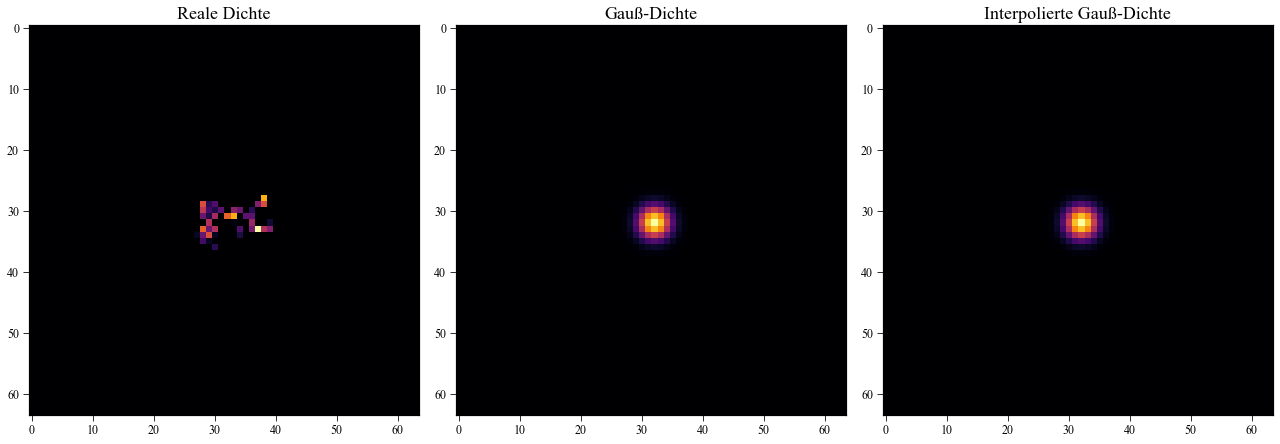

Processing Plane xy:  39%|███▉      | 71/181 [00:02<00:03, 28.83it/s]

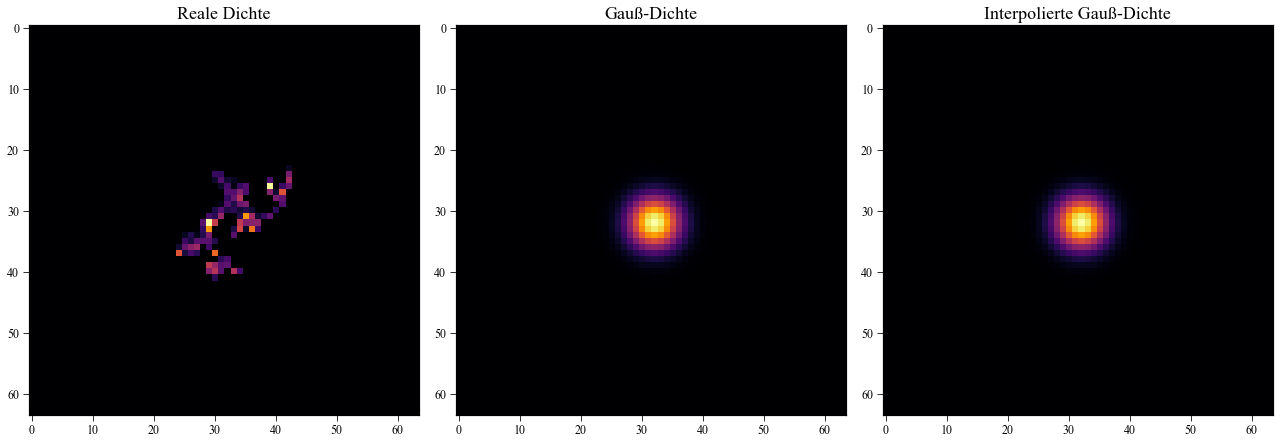

Processing Plane xy:  77%|███████▋  | 140/181 [00:05<00:01, 28.98it/s]

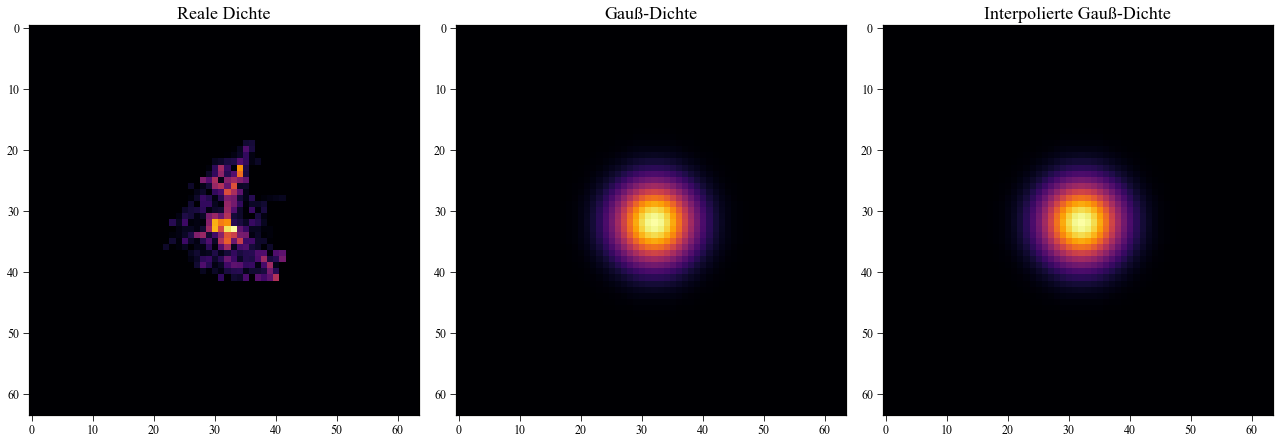

Processing Plane xy:  85%|████████▍ | 153/181 [00:06<00:01, 24.75it/s]

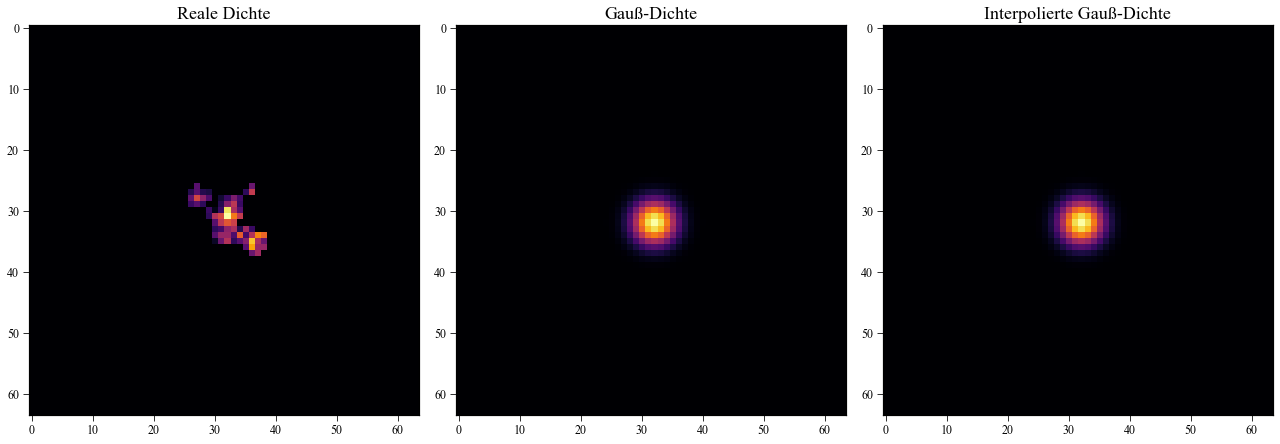

Processing Plane yz:  24%|██▍       | 44/181 [00:01<00:04, 27.99it/s]

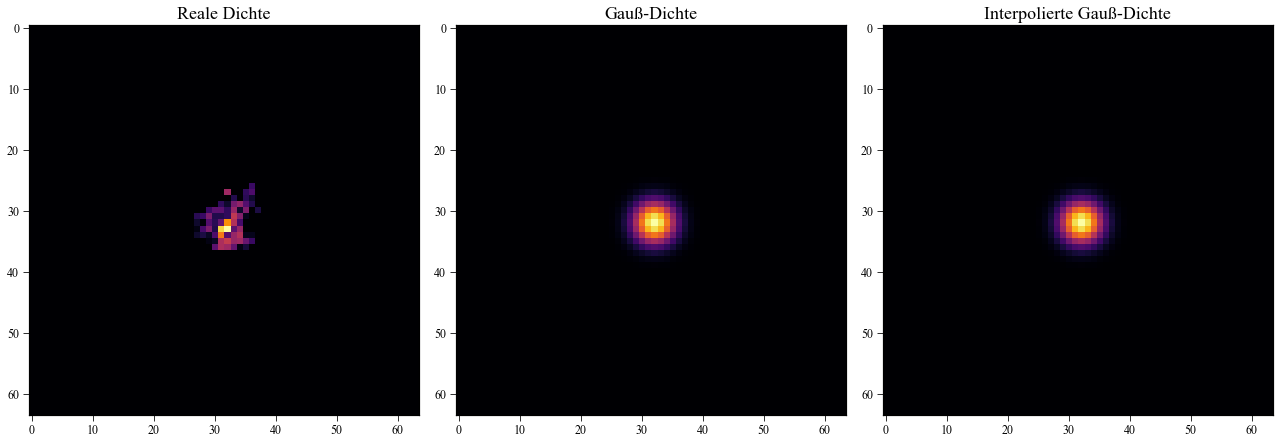

Processing Plane yz:  29%|██▉       | 53/181 [00:02<00:05, 21.95it/s]

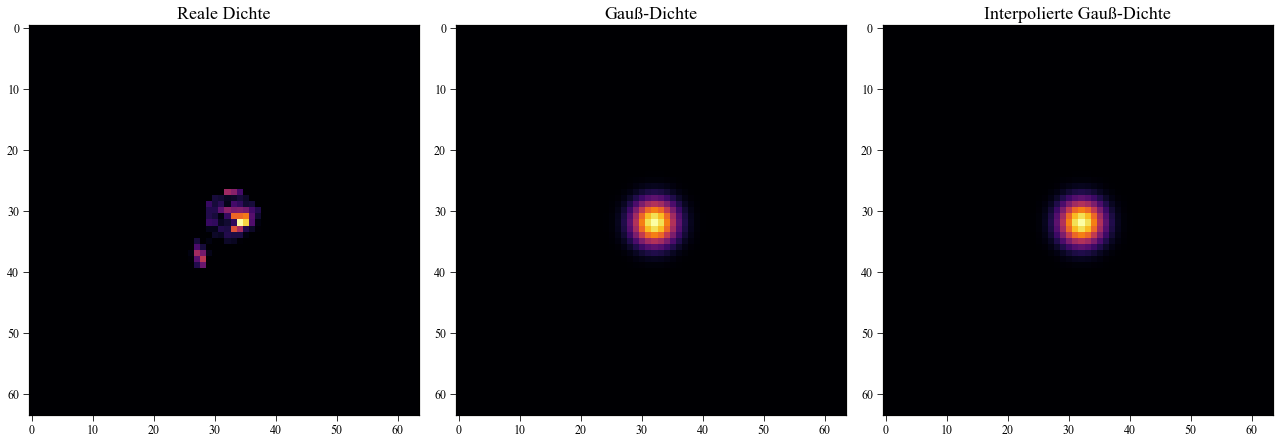

Processing Plane yz:  44%|████▎     | 79/181 [00:03<00:03, 25.55it/s]

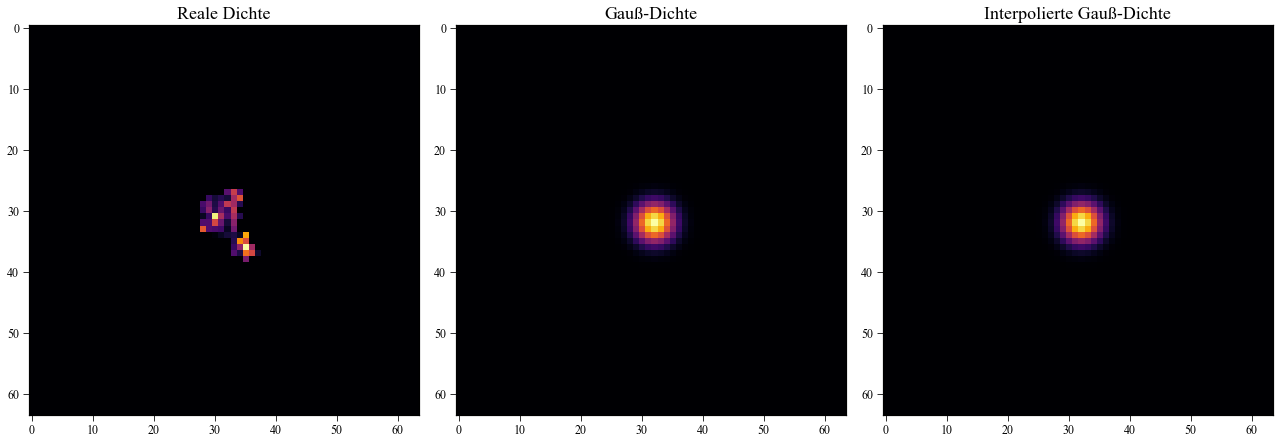

Processing Plane yz:  94%|█████████▍| 170/181 [00:07<00:00, 28.41it/s]

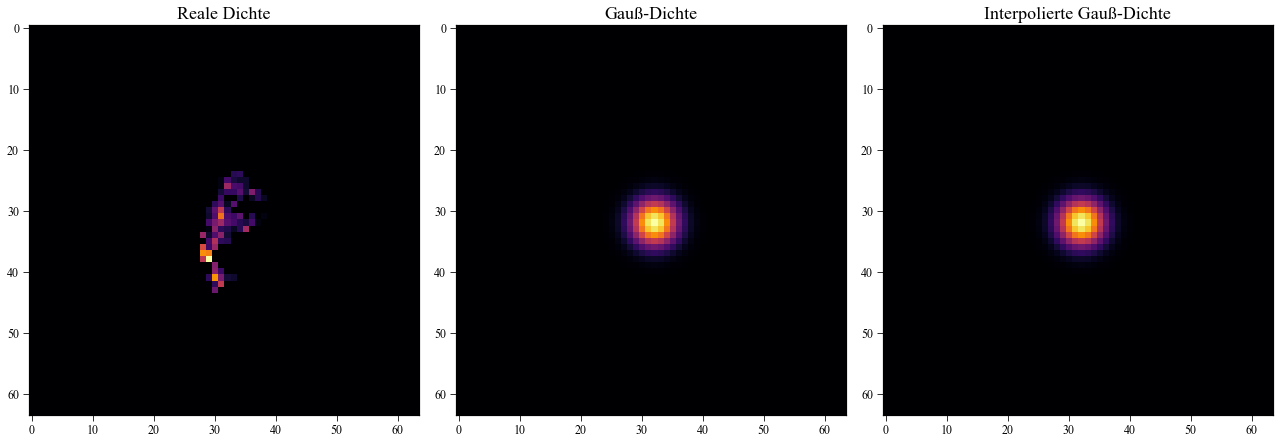

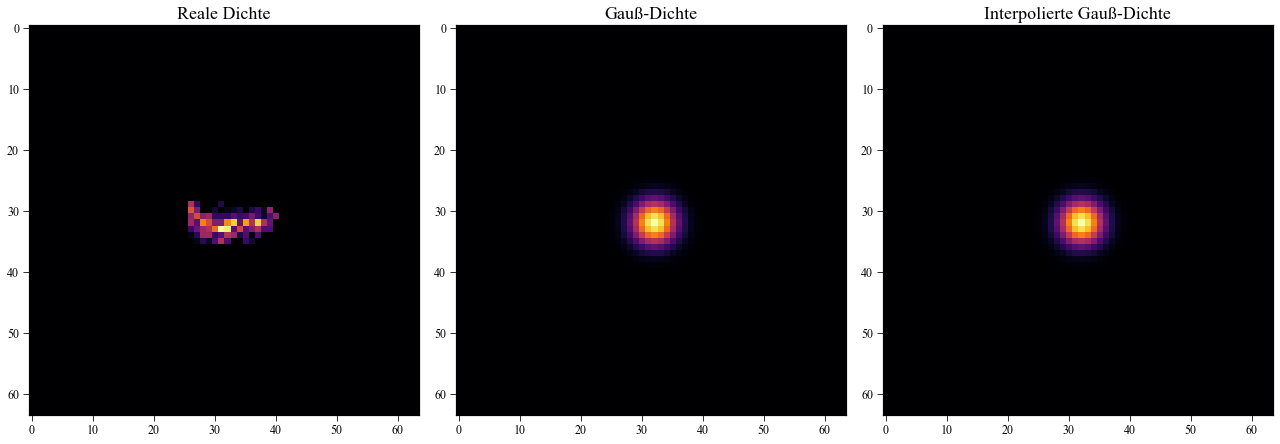

Processing Plane zx:  12%|█▏        | 22/181 [00:00<00:05, 27.77it/s]

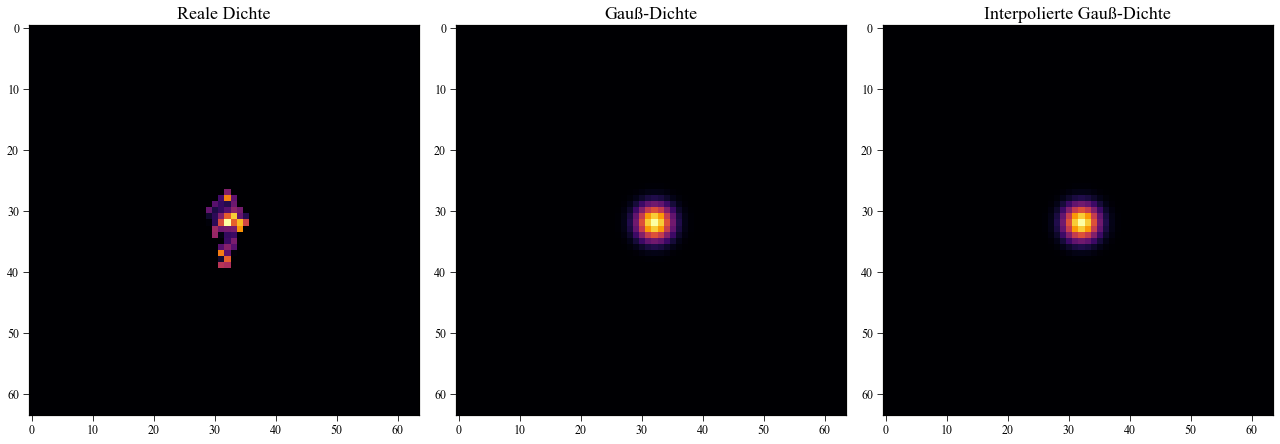

Processing Plane zx:  18%|█▊        | 32/181 [00:01<00:06, 23.66it/s]

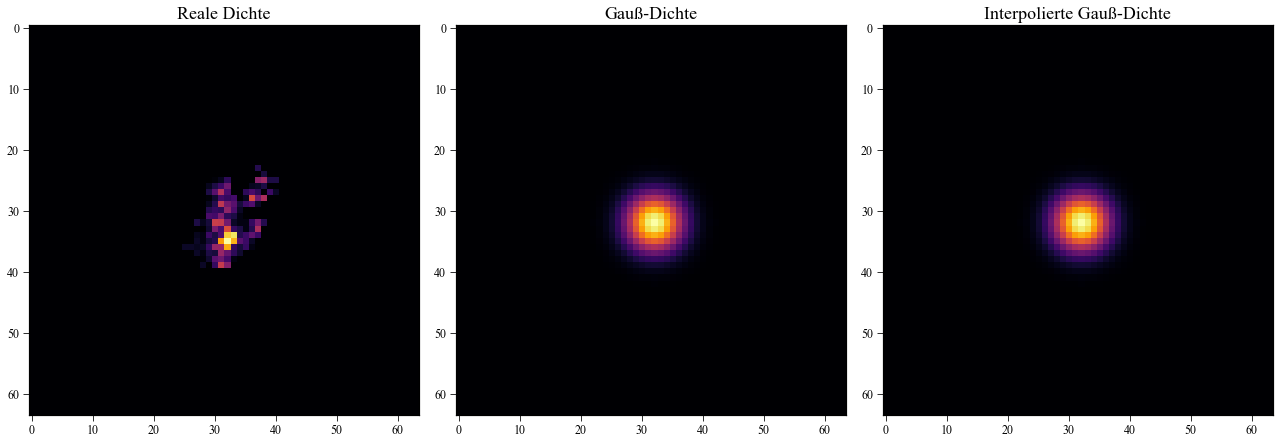

Processing Plane zx:  20%|█▉        | 36/181 [00:01<00:07, 18.70it/s]

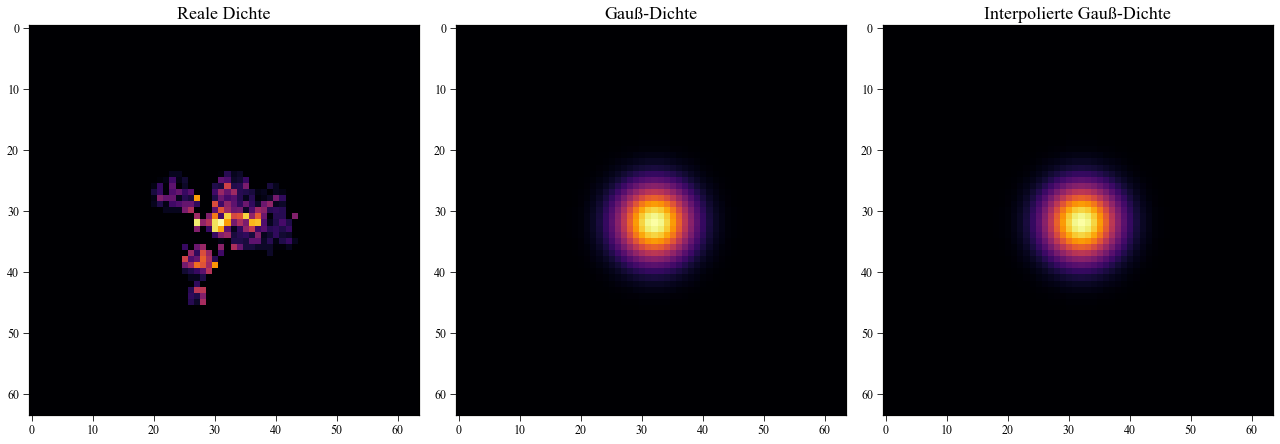

Processing Plane zx:  27%|██▋       | 48/181 [00:02<00:06, 20.70it/s]

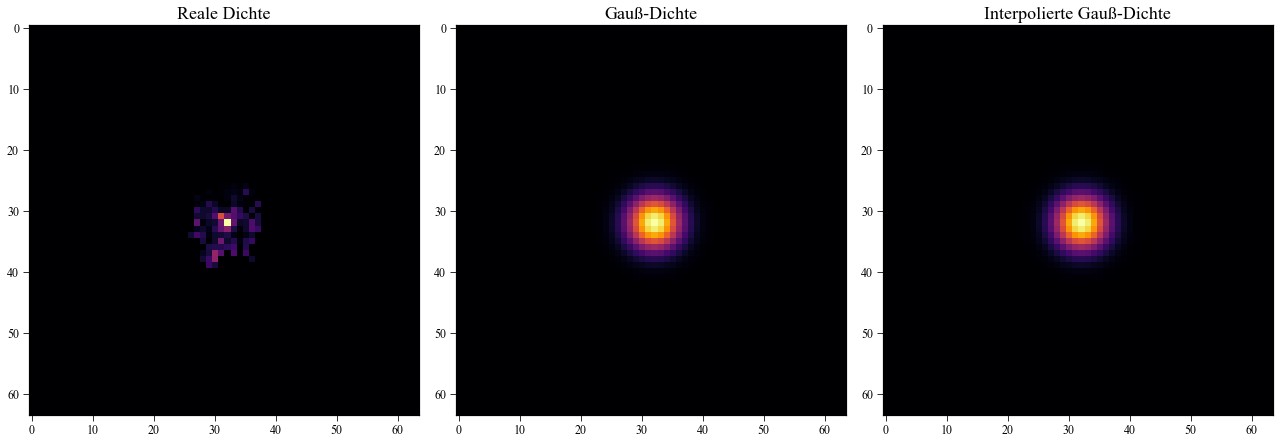

Processing Plane zx: 100%|██████████| 181/181 [00:07<00:00, 24.34it/s]

All done! Results in 'txtfiles/GAUSS_r2_results.txt'.


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator
from skimage.measure import label, regionprops
import glob
import math  # Import math for mathematical operations

def create_gaussian_density(grid_shape, std_d, mean=(32, 32)):
    nx, ny = grid_shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    gauss_density = np.exp(-((X - mean[0]) ** 2 + (Y - mean[1]) ** 2) / (2 * std_d ** 2))
    return gauss_density / np.sum(gauss_density)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return np.nan
    return 1 - (ss_res / ss_tot)

def compute_r2_row_col(real_data, model_data):
    row_sum_real = real_data.sum(axis=1)
    row_sum_model = model_data.sum(axis=1)
    if row_sum_real.sum() == 0 or row_sum_model.sum() == 0:
        return np.nan
    row_sum_real /= row_sum_real.sum()
    row_sum_model /= row_sum_model.sum()

    col_sum_real = real_data.sum(axis=0)
    col_sum_model = model_data.sum(axis=0)
    if col_sum_real.sum() == 0 or col_sum_model.sum() == 0:
        return np.nan
    col_sum_real /= col_sum_real.sum()
    col_sum_model /= col_sum_model.sum()

    r2_row = r2_score(row_sum_real, row_sum_model)
    r2_col = r2_score(col_sum_real, col_sum_model)
    return (r2_row + r2_col) / 2.0

def main():
    output_file = "txtfiles/GAUSS_r2_results.txt"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)  # Ensure the directory exists
    with open(output_file, "w") as f_out:
        f_out.write("plane\tslice\tbubble_id\tvolume\tECC\tr2_percent\n")

    planes = ['xy', 'yz', 'zx']
    slice_range = range(10, 191)
    for plane in planes:
        for slice_num in tqdm(slice_range, desc=f"Processing Plane {plane}"):
            bubble_files = glob.glob(f"{plane}_extracted_bubbles/isolated_bubbles/slice_{slice_num}_bubble_*_isolated.npy")
            bubble_ids = [int(os.path.basename(f).split('_')[3]) for f in bubble_files]

            for bubble_id in bubble_ids:
                density_path = f"{plane}_extracted_bubbles/halo_density_patches/slice_{slice_num}_bubble_{bubble_id}_halo_density_filtered.npy"
                bubble_path  = f"{plane}_extracted_bubbles/isolated_bubbles/slice_{slice_num}_bubble_{bubble_id}_isolated.npy"

                if not os.path.exists(density_path) or not os.path.exists(bubble_path):
                    continue

                density_grid = np.load(density_path)
                bubble_data  = np.load(bubble_path)
                nx, ny = density_grid.shape

                labeled = label(bubble_data > 0)
                if labeled.max() == 0:
                    bubble_volume = 0
                    bubble_ecc = 0.0
                else:
                    props = regionprops(labeled)
                    main_region = max(props, key=lambda p: p.area)
                    bubble_volume = main_region.area
                    bubble_ecc = main_region.eccentricity

                if bubble_volume == 0:
                    continue  # Skip bubbles with zero volume to avoid division by zero

                # Calculate the radius from the bubble volume (assuming circular shape)
                radius = math.sqrt(bubble_volume / math.pi)

                # Calculate standard deviation to ensure ~99% of Gaussian is within the bubble
                std_dev = radius / 2.0  # Approximately sigma = r / 3 for 99% containment

                # Enforce a minimum standard deviation to avoid extremely narrow Gaussians
                std_dev = max(1.0, std_dev)

                gaussian_density = create_gaussian_density((nx, ny), std_d=std_dev)

                # Interpolate the density grids without smoothing
                real_interp  = RegularGridInterpolator((np.arange(nx), np.arange(ny)), density_grid,  bounds_error=False, fill_value=0)
                model_interp = RegularGridInterpolator((np.arange(nx), np.arange(ny)), gaussian_density, bounds_error=False, fill_value=0)
                grid_x, grid_y = np.meshgrid(np.linspace(0, ny - 1, nx), np.linspace(0, nx - 1, ny))
                fine_real  = real_interp((grid_y, grid_x))
                fine_model = model_interp((grid_y, grid_x))

                # Compute R² score on the interpolated data without smoothing
                r2_val = compute_r2_row_col(fine_real, fine_model)
                if np.isnan(r2_val):
                    continue
                r2_percent = 100.0 * r2_val

                with open(output_file, "a") as f_out:
                    f_out.write(f"{plane}\t{slice_num}\t{bubble_id}\t{bubble_volume}\t{bubble_ecc:.4f}\t{r2_percent:.2f}\n")

                if np.random.rand() < 0.001:  # Random selection of some bubbles to plot
                    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Increased figure size for clarity
                    axes[0].imshow(density_grid, cmap='inferno')
                    axes[0].set_title('Reale Dichte')  # Real Density
                    axes[1].imshow(gaussian_density, cmap='inferno')
                    axes[1].set_title('Gauß-Dichte')  # Gaussian Density
                    axes[2].imshow(fine_model, cmap='inferno')  # Changed from smoothed_model to fine_model
                    axes[2].set_title('Interpolierte Gauß-Dichte')  # Interpolated Gaussian Density
                    plt.tight_layout()
                    plt.show()

    print(f"All done! Results in '{output_file}'.")

if __name__ == "__main__":
    main()


Average R² (%): 67.92932504604052


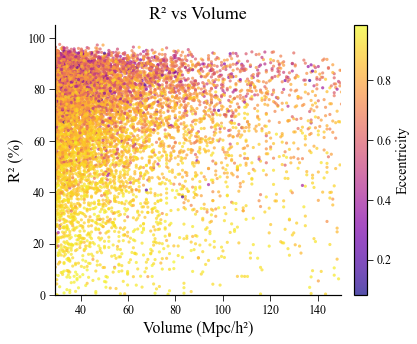

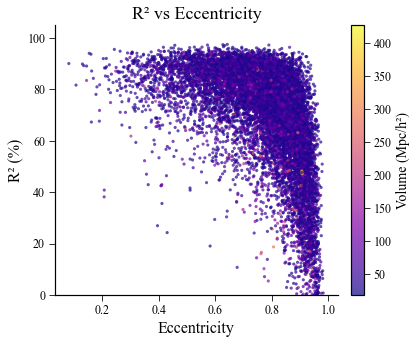

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/GAUSS_r2_results.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('images/R2_analysis/'+save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='GaussR2_vs_Volume_z9.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='GaussR2_vs_Eccentricity_z9.pdf'
)


# $z=8$

Average R² (%): 76.2855837937385


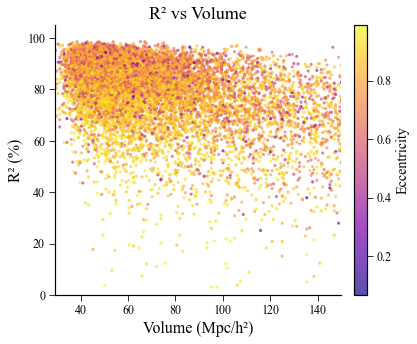

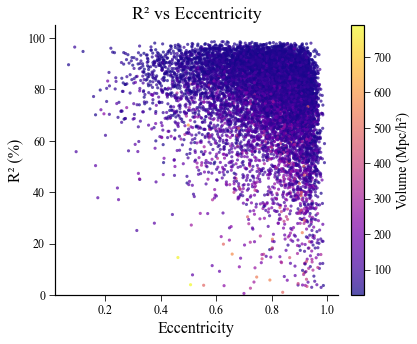

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/z08r2_results_all_planes_8_512.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Volume_z8.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Eccentricity_z8.pdf'
)


# $z=9$

Average R² (%): 82.65075782688766


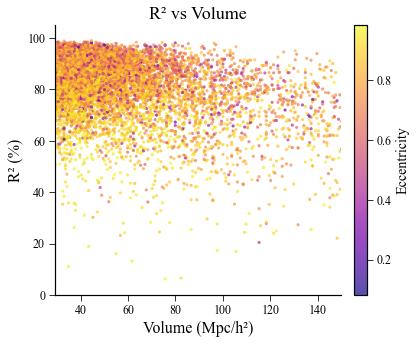

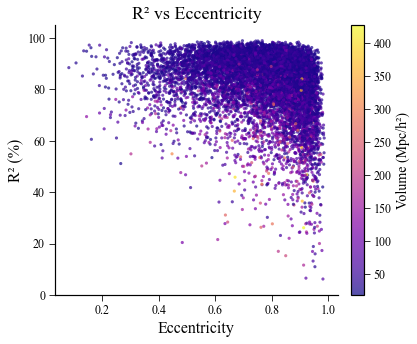

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/r2_results_all_planes_8_512.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Volume_z9.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Eccentricity_z9.pdf'
)


# $z=10$

Average R² (%): 87.716237858595


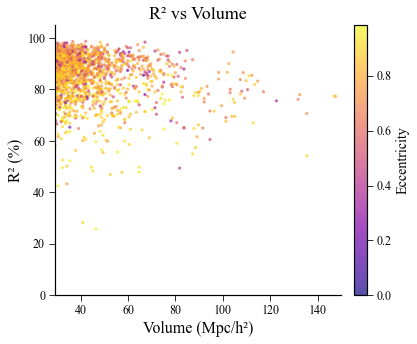

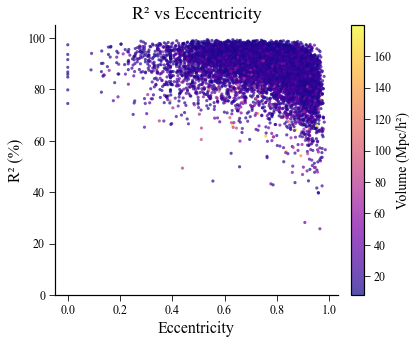

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/z10r2_results_all_planes_8_512.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Volume_z10.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Eccentricity_z10.pdf'
)


# Combined

Average R² (%): 82.21420748925722


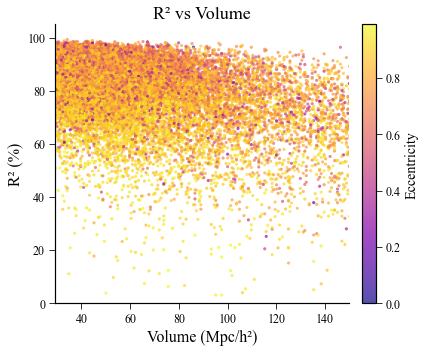

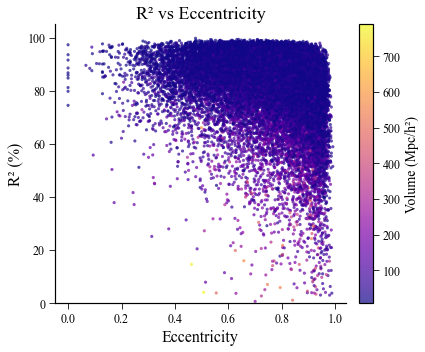

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/z08r2_results_all_planes_8_512.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))
file_path = 'txtfiles/z09r2_results_all_planes_8_512.txt'
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))
file_path = 'txtfiles/z10r2_results_all_planes_8_512.txt'
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))
data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Volume_zall.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='R2_vs_Eccentricity_zall.pdf'
)


Average R² (%): 82.21420748925722


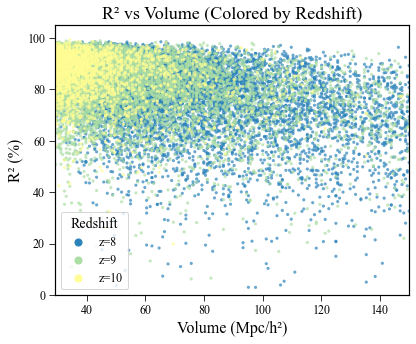

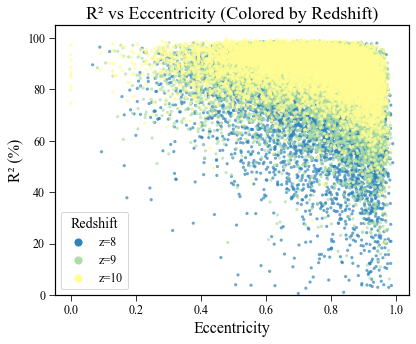

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2

# Function to load data with redshift labels
def load_data(file_path, redshift):
    data = []
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file at {file_path} does not exist.")
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() and not line.startswith("plane"):
                parts = line.split()
                volume = float(parts[3])
                ecc = float(parts[4])
                r2_percent = float(parts[5])
                data.append((volume, ecc, r2_percent, redshift))
    return data

# Load data for each redshift
data = []
data += load_data('txtfiles/z08r2_results_all_planes_8_512.txt', redshift=8)
data += load_data('txtfiles/z09r2_results_all_planes_8_512.txt', redshift=9)
data += load_data('txtfiles/z10r2_results_all_planes_8_512.txt', redshift=10)

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]
redshifts = data[:, 3]

print("Average R² (%):", np.average(r2_percent))

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_redshift(x, y, redshift, title, xlabel, ylabel, save_name):
    """
    Creates a scatter plot colored by redshift.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - redshift: Redshift values for coloring the points.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - save_name: Filename to save the plot.
    """
    # Define colors for each redshift
    redshift_colors = {
    8: '#2b83ba',  # Cool teal blue
    9: '#abdda4',  # Soft mint green
    10: '#fffd93'  # Warm orange
    }

    colors = [redshift_colors[int(z)] for z in redshift]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size

    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=colors,
        s=10,
        alpha=0.7,
        edgecolors='none'
    )

    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)

    # Add legend for redshifts
    for z, color in redshift_colors.items():
        ax.scatter([], [], color=color, label=f'z={z}', s=50)
    ax.legend(title="Redshift", fontsize=12)
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('images/R2_analysis/'+save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Plot 1: R² vs Volume, color by Redshift
plot_scatter_with_redshift(
    x=volumes,
    y=r2_percent,
    redshift=redshifts,
    title='R² vs Volume (Colored by Redshift)',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    save_name='R2_vs_Volume_zall_redshift.pdf'
)

# Plot 2: R² vs Eccentricity, color by Redshift
plot_scatter_with_redshift(
    x=ecc,
    y=r2_percent,
    redshift=redshifts,
    title='R² vs Eccentricity (Colored by Redshift)',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    save_name='R2_vs_Eccentricity_zall_redshift.pdf'
)


# 256

Average R² (%): 59.857406077348074


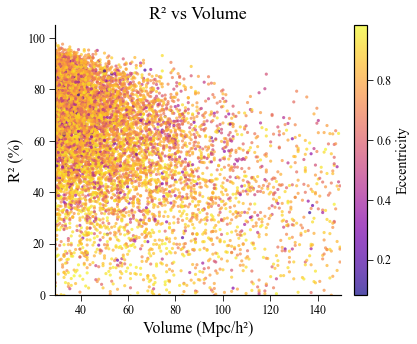

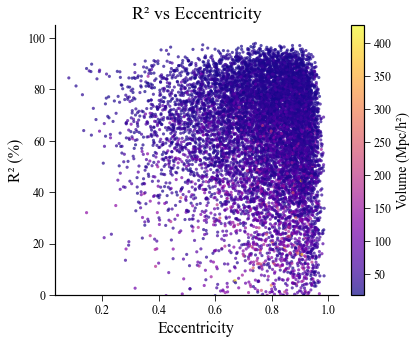

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/256r2_results_all_planes.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('images/R2_analysis/'+save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='oldR2_vs_Volume_z9.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='oldR2_vs_Eccentricity_z9.pdf'
)


# 256 with 6 Layers, OVERLONG512GLOW.pth

Average R² (%): 83.62038177046051


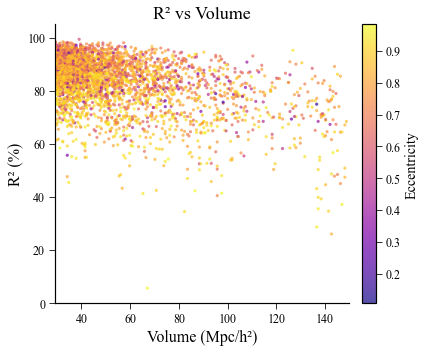

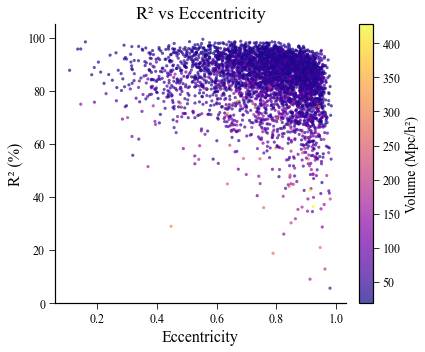

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
from matplotlib import rcParams

# ------------------------ Configuration for Professional Plots ------------------------

# Update rcParams for publication-quality figures
rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 1.5,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'savefig.dpi': 300,  # High resolution for publication
    'savefig.format': 'pdf',  # Vector format
    'contour.negative_linestyle': 'solid'
})

# ------------------------------ Data Loading ------------------------------

V_cell = 0.610  # Mpc^2/h^2
file_path = 'txtfiles/OVERz09r2_results_all_planes_8_512.txt'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file at {file_path} does not exist.")

data = []
with open(file_path, 'r') as file:
    for line in file:
        if line.strip() and not line.startswith("plane"):
            parts = line.split()
            volume = float(parts[3])
            ecc = float(parts[4])
            r2_percent = float(parts[5])
            data.append((volume, ecc, r2_percent))

data = np.array(data)
volumes = data[:, 0] * V_cell
ecc = data[:, 1]
r2_percent = data[:, 2]

print("Average R² (%):", np.average(r2_percent))

# -------------------------- Coverage Contours Function --------------------------

def calculate_coverage_contours(x, y, coverage_levels):
    """
    Compute density thresholds for each coverage fraction in coverage_levels.
    """
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density_values = kde(xy)

    # Sort densities descending: highest to lowest
    sorted_dens = np.sort(density_values)[::-1]
    cumsum = np.cumsum(sorted_dens)
    cumsum /= cumsum[-1]  # Normalize to 1

    thresholds = []
    for coverage in coverage_levels:
        idx = np.searchsorted(cumsum, coverage)
        idx = min(idx, len(sorted_dens) - 1)
        thresholds.append(sorted_dens[idx])
    return kde, thresholds

# ----------------------------- Plotting Function -----------------------------

def plot_scatter_with_contours(x, y, color_by, color_label, title, xlabel, ylabel, 
                               coverage_levels, percentiles, save_name):
    """
    Creates a scatter plot with density-based contour lines.
    
    Parameters:
    - x, y: Data for the scatter plot.
    - color_by: Data to color the scatter points.
    - color_label: Label for the colorbar.
    - title, xlabel, ylabel: Titles and labels for the plot.
    - coverage_levels: List of coverage levels for contours.
    - percentiles: List of percentile values for horizontal lines.
    - save_name: Filename to save the plot.
    """
    # Calculate coverage contours
    kde, thresholds = calculate_coverage_contours(x, y, coverage_levels)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 5))  # Standard journal figure size
    
    # Scatter plot
    scatter = ax.scatter(
        x,
        y,
        c=color_by,
        cmap='viridis' if color_label == 'Volume' else 'plasma',
        s=10,            # Increased marker size for visibility
        alpha=0.7,
        edgecolors='none'
    )
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(color_label, fontsize=14)
    
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Horizontal percentile lines
    thresholds_percentiles = np.percentile(y, [100 - p for p in percentiles])
    for p, t in zip(percentiles, thresholds_percentiles):
        ax.axhline(y=t, linestyle='--', color='red', linewidth=1.5)
        ax.text(
            0.98, t + 1,  # Position near the right edge
            f'{p}%',
            color='red',
            fontsize=12,
            ha='right',
            va='bottom',
            transform=ax.get_yaxis_transform()
        )
    
    # Contour lines
    x_grid = np.linspace(x.min(), x.max(), 200)
    y_grid = np.linspace(y.min(), y.max(), 200)
    X, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X.ravel(), Y_grid.ravel()])).reshape(X.shape)
    
    contour_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Custom colors for contours
    for coverage, thr, color in zip(coverage_levels, thresholds, contour_colors):
        cont = ax.contour(
            X, Y_grid, Z,
            levels=[thr],
            colors=color,
            linestyles='--',
            linewidths=2
        )
        # Label contours
        fmt = {thr: f'{int(coverage * 100)}%'}
        ax.clabel(cont, inline=True, fontsize=12, inline_spacing=5,
                  manual=False, fmt=lambda x: f'{int(coverage * 100)}%')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set limits
    if xlabel == 'Volume (Mpc/h²)':
        ax.set_xlim(29, 150)
    elif xlabel == 'Eccentricity':
        ax.set_xlim(ecc.min() - 0.05, ecc.max() + 0.05)
    ax.set_ylim(0, 105)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('images/R2_analysis/'+save_name, bbox_inches='tight')
    plt.show()

# ---------------------------- Generate the Plots -----------------------------

# Define coverage levels and percentiles
coverage_levels = []
percentiles = []

# Plot 1: R² vs Volume, color by ECC
plot_scatter_with_contours(
    x=volumes,
    y=r2_percent,
    color_by=ecc,
    color_label='Eccentricity',
    title='R² vs Volume',
    xlabel='Volume (Mpc/h²)',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='OVERR2_vs_Volume_z9.pdf'
)

# Plot 2: R² vs Eccentricity, color by Volume
plot_scatter_with_contours(
    x=ecc,
    y=r2_percent,
    color_by=volumes,
    color_label='Volume (Mpc/h²)',
    title='R² vs Eccentricity',
    xlabel='Eccentricity',
    ylabel='R² (%)',
    coverage_levels=coverage_levels,
    percentiles=percentiles,
    save_name='OVERR2_vs_Eccentricity_z9.pdf'
)
